# Density-Based Spatial Clustering of Applications with Noise from Scratch
***
## Table of Contents
1. [Introduction](#1-introduction)
***

In [301]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from typing import List

## 1. Introduction
Density-Based Spatial Clustering of Applications with Noise (DBSCAN) is a density-based clustering algorithm (unsupervised learning method) that groups data points in high-density regions while identifying outliers in low-density areas. Unlike centroid-based methods like K-Means, it discovers arbitrarily shaped clusters without requiring pre-specified cluster counts.

### Key Concepts
- $\epsilon$: Radius that defines the neighbourhood of each point.
- $\text{MinPts}$: Minimum number of points required in the $\epsilon$-neighbourhood to form a cluster.
- DBSCAN algorithm identifies the following three types of points during the process:
    - **Core point**: A point that has at least $\text{MinPts}$ neighbours (including itself) within $\epsilon$.
    - **Border point**: A point within $\epsilon$ of a core point but has less than  $\text{MinPts}$ neighbours.
    - **Noise point**: A point that is neither core nor border; considered as an outlier.

### Steps
1. Normalise features for equal scaling.
2. Identify core points.
3. Expand clusters from core points via density reachability while assigning border points (core -> border).
4. Label non-reachable points as noise points.

## 2. Loading Data

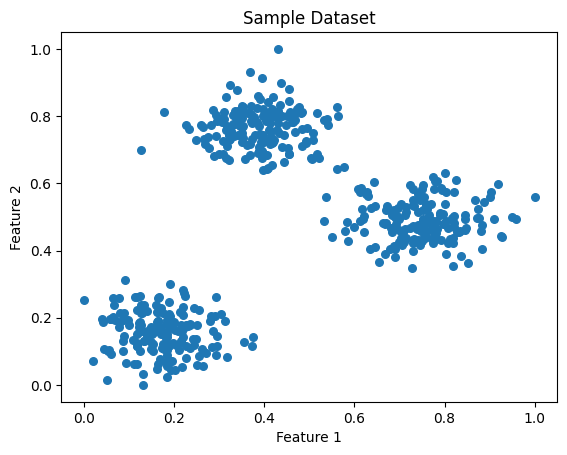

In [302]:
# Generate 500 samples, 3 cluster centers, 2 features (for 2D visualisation)
X, y = make_blobs(n_samples=500, centers=3, cluster_std=1.6,
                  #   c=y, cmap="viridis",
                  n_features=2, random_state=42)

scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X))

# Visualise the dataset
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], s=30)
plt.title("Sample Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

In [303]:
X.describe()

,0,1
count,500.000000,500.000000
mean,0.437284,0.470313
std,0.250494,0.255426
min,0.000000,0.000000
25%,0.217315,0.203571
50%,0.394213,0.484234
75%,0.693504,0.722237
max,1.000000,1.000000


## 3. Identifying Core Points
For each data point, we compute the Euclidean distance to count neighbours within the range $\epsilon$. Mark them as 'core' if the number of neighbours is $\geq \text{MinPts}$. Euclidean distance is calculated as:

\begin{align*}
\sqrt{\sum_{i=1}^{n} (a_i - b_i)^2}
\end{align*}

In [304]:

def find_neighbours(data: pd.DataFrame, point_idx: int, eps: float):
    """Return indices of points within eps distance of data[point_idx]."""
    data_np = data.values  # Convert to np.array
    distances = np.linalg.norm(
        data_np - data_np[point_idx], axis=1)  # Vectorised
    # Get indices where distance <= eps
    neighbours = np.where(distances <= eps)[0].tolist()
    return neighbours

A sample point (X.iloc[100]) has 34 neighbours.


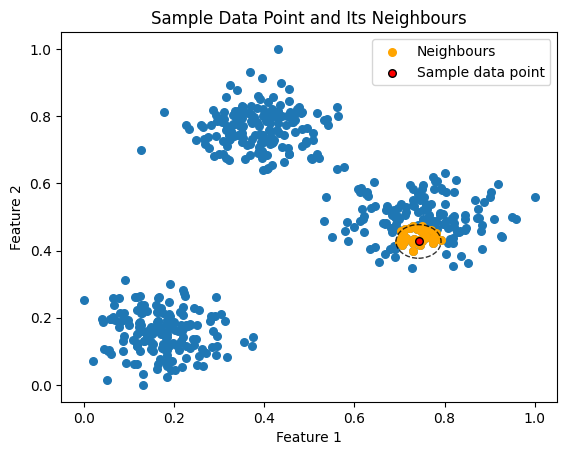

In [305]:
eps = 0.05
min_pts = 5
test_point_idx = 100
test_neighbours = find_neighbours(X, [test_point_idx], eps)
print(
    f'A sample point (X.iloc[{test_point_idx}]) has {len(test_neighbours)} neighbours.')
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], s=30)
plt.scatter(X.iloc[test_neighbours, 0],
            X.iloc[test_neighbours, 1], s=30, c='orange', label='Neighbours')
plt.scatter(X.iloc[test_point_idx, 0],
            X.iloc[test_point_idx, 1], s=30, c='red', edgecolor='black', label='Sample data point')

circle = plt.Circle(
    (X.iloc[test_point_idx, 0], X.iloc[test_point_idx, 1]),
    radius=eps,
    color='black',
    fill=False,
    linestyle='--',
    alpha=0.8
)
plt.gca().add_patch(circle)
plt.title("Sample Data Point and Its Neighbours")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

## 4. Cluster Formation
We will expand clusters from core points using density reachability as follows:
1. Initialise cluster (starting point = `cluster_id`).
2. Iterate through the `neighbours` list.
3. Convert noise points to border points of the current cluster (noise should not have neighbours).
4. For unvisited points (`0`), assign to current cluster, check if it's a core point.
5. If core, dynamically extend the `neighbours` list with new points not already processed, enabling cluster expansion

In [306]:
def expand_cluster(data, labels, point_idx, neighbours, cluster_id, eps, min_pts):
    labels[point_idx] = cluster_id
    i = 0
    while i < len(neighbours):
        neighbor_idx = neighbours[i]
        if labels[neighbor_idx] == -1:  # Noise -> Border
            labels[neighbor_idx] = cluster_id
        elif labels[neighbor_idx] == 0:  # Unvisited
            labels[neighbor_idx] = cluster_id
            new_neighbours = find_neighbours(data, neighbor_idx, eps)
            if len(new_neighbours) >= min_pts:  # Core point
                neighbours += [n for n in new_neighbours if n not in neighbours]
        i += 1

## 5. Prediction
In the following prediction function, `labels` tracks point states:
- $0$: Unvisited
- $-1$: Noise
- $>0$: Cluster ID (e.g., 1, 2, ...)

The `labels` is initialised with all $0$ s.

In [307]:
def predict(data, eps, min_pts):
    n = len(data)
    labels = np.zeros(n)
    cluster_id = 0

    for i in tqdm(range(n)):
        if labels[i] != 0:
            continue

        neighbours = find_neighbours(data, i, eps)
        if len(neighbours) < min_pts:
            labels[i] = -1  # Mark as noise
        else:
            cluster_id += 1
            expand_cluster(data, labels, i, neighbours,
                           cluster_id, eps, min_pts)
    return labels


predicted_labels = predict(X, eps, min_pts)
X['cluster_label'] = predicted_labels.astype(int)

100%|██████████| 500/500 [00:00<00:00, 23646.13it/s]


In [308]:
X.head()

,0,1,cluster_label
0,0.261414,0.106147,1
1,0.532724,0.487513,-1
2,0.928071,0.441000,-1
3,0.357699,0.672051,2
4,0.848091,0.465689,3


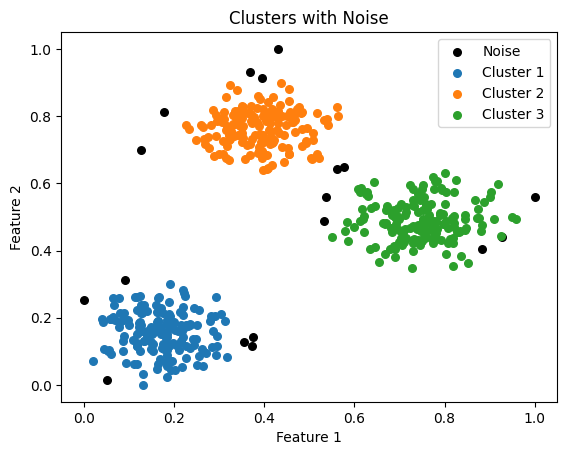

In [309]:
# Plot clusters (labels >= 0)
def visualise_clusters(X: pd.DataFrame) -> None:
    for label in sorted(X['cluster_label'].unique()):
        if label == -1:
            # Noise points
            plt.scatter(
                X.loc[X['cluster_label'] == -1, X.columns[0]],
                X.loc[X['cluster_label'] == -1, X.columns[1]],
                s=30, c='black', label='Noise'
            )
        else:
            # Cluster points
            plt.scatter(
                X.loc[X['cluster_label'] == label, X.columns[0]],
                X.loc[X['cluster_label'] == label, X.columns[1]],
                s=30, label=f'Cluster {label}'
            )

    plt.title("Clusters with Noise")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.show()

visualise_clusters(X)